In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load data

In [ ]:
import os
image_dir = '/content/drive/MyDrive/TA_Jonathan/dataset'
filename = []
label = []

for dir_name in os.listdir(image_dir):
    for file in os.listdir(os.path.join(image_dir, dir_name)):
        filename.append(os.path.join(dir_name, file))
        label.append(dir_name)

In [ ]:
print(len(filename))

2000


In [ ]:
import pandas as pd
data = {"filename": filename, "label": label}
df = pd.DataFrame(data)
df_shuffled = df.sample(frac=1).reset_index(drop=True)

In [ ]:
print(df_shuffled['label'].value_counts())

label
chihuahua            200
Sphynx               200
Persian              200
american_pit_bull    200
Ragdoll              200
american_bulldog     200
pug                  200
pomeranian           200
British              200
Russian              200
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_shuffled, test_size=0.2, random_state=42, stratify=df_shuffled['label'])
print("Train dataset: ", train_df['label'].value_counts())
print("\nTesting dataset: ", test_df['label'].value_counts())

Train dataset:  label
pug                  160
pomeranian           160
Persian              160
chihuahua            160
British              160
american_pit_bull    160
Ragdoll              160
Sphynx               160
american_bulldog     160
Russian              160
Name: count, dtype: int64

Testing dataset:  label
chihuahua            40
american_pit_bull    40
Persian              40
Ragdoll              40
american_bulldog     40
Sphynx               40
pomeranian           40
pug                  40
Russian              40
British              40
Name: count, dtype: int64


Data augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

valid_data_generator = validation_datagen.flow_from_dataframe(
    test_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1600 validated image filenames belonging to 10 classes.
Found 400 validated image filenames belonging to 10 classes.


Define Model


---

*MobileNetV2 as the base model*

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

def build_model():
    pretrained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    for layer in pretrained_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(pretrained_model.output)
    x = Dropout(0.5)(x)
    output = Dense(10, activation='softmax')(x)
    model = Model(pretrained_model.input, output)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=5,
                                   restore_best_weights=True)
    return model, early_stopping

In [ ]:
model, early_stopping= build_model()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
hist = model.fit(
    train_data_generator,
    steps_per_epoch=len(train_data_generator),
    epochs=20,
    validation_data=valid_data_generator,
    validation_steps=len(valid_data_generator),
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 788s 16s/step - accuracy: 0.3463 - loss: 1.9609 - val_accuracy: 0.8450 - val_loss: 0.5296
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7557 - loss: 0.6835 - val_accuracy: 0.8625 - val_loss: 0.3774
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8173 - loss: 0.4781 - val_accuracy: 0.8875 - val_loss: 0.3161
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8294 - loss: 0.4641 - val_accuracy: 0.9050 - val_loss: 0.2789
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8621 - loss: 0.3785 - val_accuracy: 0.9200 - val_loss: 0.2585
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.8569 - loss: 0.3893 - val_accuracy: 0.9125 - val_loss: 0.2725
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8678 - loss: 0.3526 - val_accuracy: 0.9150 - val_loss: 0.2439
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.8919 - loss: 0.3016 - val_accuracy: 0.9150 - 

In [ ]:
save_dir = '/content/drive/MyDrive/TA_Jonathan/model/training82'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
model.save(os.path.join(save_dir, 'model.h5'))

Visualization

13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


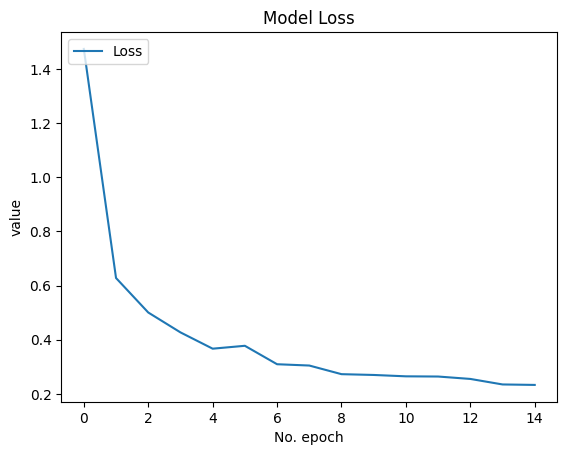

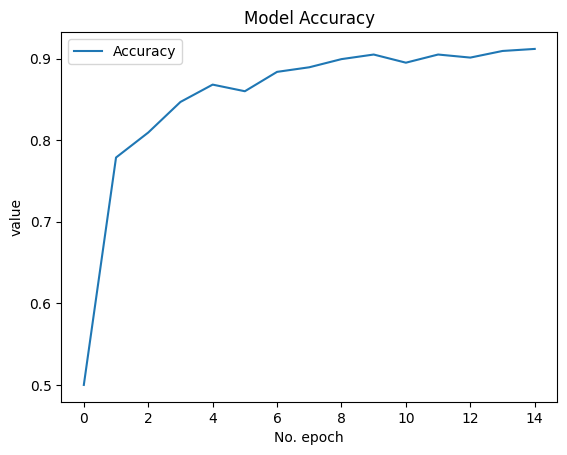

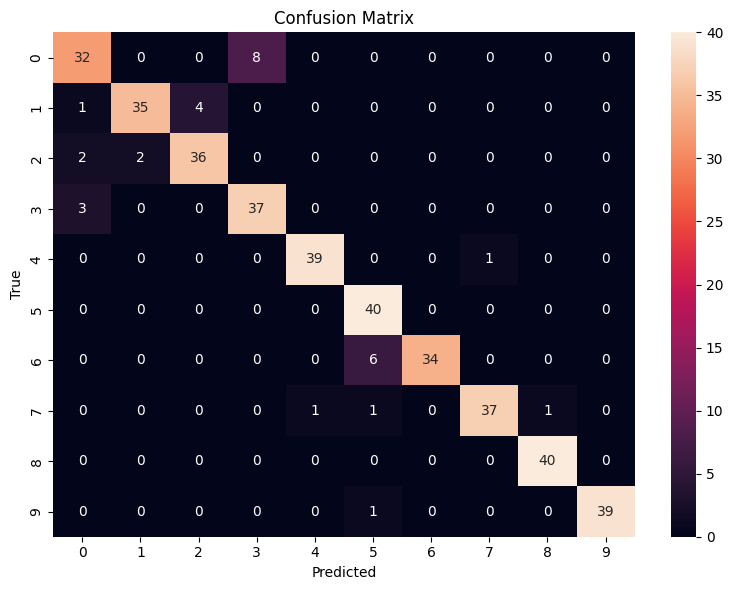

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_predict = model.predict(valid_data_generator)
y = np.asarray(valid_data_generator.labels)
y_predict_labels = np.argmax(y_predict, axis=1)

plt.plot(hist.history['loss'], label='Loss')
plt.title(f'Model Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.savefig(os.path.join(save_dir, f'plot_loss.png'))
plt.show()

plt.plot(hist.history['accuracy'], label='Accuracy')
plt.title(f'Model Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.savefig(os.path.join(save_dir, f'plot_accuracy.png'))
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y, y_predict_labels), annot=True, fmt=".0f")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, f'confusion_matrix.png'))
plt.show()

In [ ]:
print(train_data_generator.class_indices)

{'British': 0, 'Persian': 1, 'Ragdoll': 2, 'Russian': 3, 'Sphynx': 4, 'american_bulldog': 5, 'american_pit_bull': 6, 'chihuahua': 7, 'pomeranian': 8, 'pug': 9}
